In [53]:
# Library imports
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder

In [3]:
!ls

anime.csv  anime.ipynb	rating_large.csv


#### **Load data**

In [4]:
anime = pd.read_csv('anime.csv')
anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [6]:
rating = pd.read_csv('rating_large.csv')
rating

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [11]:
print('users: ', rating.user_id.nunique())
print('items: ', rating.anime_id.nunique())
print('ratings: ', rating.shape[0])
rating.rating.value_counts()

users:  73515
items:  11200
ratings:  7813737


 8     1646019
-1     1476496
 7     1375287
 9     1254096
 10     955715
 6      637775
 5      282806
 4      104291
 3       41453
 2       23150
 1       16649
Name: rating, dtype: int64

In [12]:
# filter data with ratings 8 and above as positive recommendations
good = rating[rating.rating >= 8]
good

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813730,73515,13659,8
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [13]:
print('users: ', good.user_id.nunique())
print('items: ', good.anime_id.nunique())
print('ratings: ', good.shape[0])
good.rating.value_counts()

users:  69002
items:  8266
ratings:  3855830


8     1646019
9     1254096
10     955715
Name: rating, dtype: int64

In [25]:
user_threshold = 50
anime_threshold = 100
data = good.groupby('user_id').filter(lambda x: len(x) >= user_threshold).groupby('anime_id').filter(lambda x: len(x) >= anime_threshold)
data = data.groupby('user_id').filter(lambda x: len(x) >= user_threshold).groupby('anime_id').filter(lambda x: len(x) >= anime_threshold)
data = data.groupby('user_id').filter(lambda x: len(x) >= user_threshold).groupby('anime_id').filter(lambda x: len(x) >= anime_threshold)
data = data.groupby('user_id').filter(lambda x: len(x) >= user_threshold).groupby('anime_id').filter(lambda x: len(x) >= anime_threshold)
data = data.groupby('user_id').filter(lambda x: len(x) >= user_threshold).groupby('anime_id').filter(lambda x: len(x) >= anime_threshold)
data = data.groupby('user_id').filter(lambda x: len(x) >= user_threshold).groupby('anime_id').filter(lambda x: len(x) >= anime_threshold)
data = data.groupby('user_id').filter(lambda x: len(x) >= user_threshold).groupby('anime_id').filter(lambda x: len(x) >= anime_threshold)
data = data.groupby('user_id').filter(lambda x: len(x) >= user_threshold).groupby('anime_id').filter(lambda x: len(x) >= anime_threshold)
data = data.groupby('user_id').filter(lambda x: len(x) >= user_threshold).groupby('anime_id').filter(lambda x: len(x) >= anime_threshold)
print(data.user_id.nunique())
print(data.anime_id.nunique())
data

24099
2839


,user_id,anime_id,rating
807,7,30,10
808,7,31,9
809,7,32,9
811,7,64,8
814,7,121,8
...,...,...,...
7813727,73515,13161,8
7813728,73515,13331,9
7813730,73515,13659,8
7813733,73515,17187,9


#### **Sample random users from data**

In [31]:
# there are 24099 users in data
# sample 2k of them randomly
np.random.seed(0)
random_users = np.random.choice(data.user_id.unique(), 2000, replace = False)
print('random users: ', random_users)

data_random = data[data.user_id.isin(random_users)]
data_random

random users:  [60062  7816 18493 ... 50634 56683 52957]


,user_id,anime_id,rating
6804,77,164,9
6805,77,199,10
6806,77,431,10
6807,77,513,8
6808,77,523,10
...,...,...,...
7810422,73485,12355,9
7810424,73485,12531,9
7810425,73485,12883,8
7810426,73485,13125,8


In [33]:
print(data_random.user_id.nunique())
print(data_random.anime_id.nunique())

2000
2839


In [35]:
data_random.user_id.value_counts()

33631    872
67296    803
21748    749
45659    721
22835    687
        ... 
18414     50
35292     50
64096     50
30571     50
34058     50
Name: user_id, Length: 2000, dtype: int64

In [36]:
data_random.anime_id.value_counts()

1535     1233
1575     1111
16498    1073
5114     1032
6547     1028
         ... 
365         4
83          3
1214        3
31368       3
22677       2
Name: anime_id, Length: 2839, dtype: int64

In [37]:
df = data_random.groupby('anime_id').filter(lambda x: len(x) >= 50)
df

,user_id,anime_id,rating
6804,77,164,9
6805,77,199,10
6806,77,431,10
6807,77,513,8
6808,77,523,10
...,...,...,...
7810422,73485,12355,9
7810424,73485,12531,9
7810425,73485,12883,8
7810426,73485,13125,8


In [38]:
df.user_id.nunique()

2000

In [39]:
df.anime_id.nunique()

1197

In [40]:
df.user_id.value_counts()

33631    593
45659    543
21748    531
22835    504
67296    484
        ... 
50989     35
44394     34
59633     33
51708     31
6883      30
Name: user_id, Length: 2000, dtype: int64

In [41]:
df.anime_id.value_counts()

1535     1233
1575     1111
16498    1073
5114     1032
6547     1028
         ... 
32370      50
343        50
531        50
28387      50
15109      50
Name: anime_id, Length: 1197, dtype: int64

In [44]:
# so each user in df watches atleast 30 anime 
# and each anime is watched by atleast 50 people 
# and no user watches more than 50% of all anime 
# approx 200k ratings
# seems like a good dataset to begin experimenting with 

In [43]:
df

,user_id,anime_id,rating
6804,77,164,9
6805,77,199,10
6806,77,431,10
6807,77,513,8
6808,77,523,10
...,...,...,...
7810422,73485,12355,9
7810424,73485,12531,9
7810425,73485,12883,8
7810426,73485,13125,8


In [45]:
df = df[['user_id', 'anime_id']]
df.columns = ['user', 'item']
df

,user,item
6804,77,164
6805,77,199
6806,77,431
6807,77,513
6808,77,523
...,...,...
7810422,73485,12355
7810424,73485,12531
7810425,73485,12883
7810426,73485,13125


In [47]:
df.to_csv('anime_data.csv', index = False)

#### **Exploring saved data**

In [49]:
os.path.getsize('anime_data.csv') >> 20
# the ratings dataset is of size 2 MB

2

In [50]:
data = pd.read_csv('anime_data.csv')
data

,user,item
0,77,164
1,77,199
2,77,431
3,77,513
4,77,523
...,...,...
207657,73485,12355
207658,73485,12531
207659,73485,12883
207660,73485,13125


In [51]:
n_users = data.user.nunique()
n_items = data.item.nunique()
n_samples = data.shape[0]
print(n_users, n_items, n_samples)

2000 1197 207662


In [54]:
# serialise users and items features
le = LabelEncoder()
data.user = le.fit_transform(data.user)
data.item = le.fit_transform(data.item)
data

,user,item
0,0,80
1,0,103
2,0,167
3,0,197
4,0,200
...,...,...
207657,1999,811
207658,1999,821
207659,1999,827
207660,1999,831


In [57]:
data.to_csv('anime_data.csv', index = False)

#### **Create adjacency matrix**

In [58]:
data = pd.read_csv('anime_data.csv')
data

,user,item
0,0,80
1,0,103
2,0,167
3,0,197
4,0,200
...,...,...
207657,1999,811
207658,1999,821
207659,1999,827
207660,1999,831


In [59]:
print(data.user.unique())
print(data.item.unique())
print(data.user.unique().max())
print(data.item.unique().max())

[   0    1    2 ... 1997 1998 1999]
[  80  103  167 ... 1150  586  730]
1999
1196


In [60]:
n_users = data.user.nunique()
n_items = data.item.nunique()
n_samples = data.shape[0]

print('users: ', n_users)
print('items: ', n_items)
print('ratings: ', n_samples)

users:  2000
items:  1197
ratings:  207662


In [61]:
density = n_samples / (n_users * n_items)
print('Density of interaction matrix: ', density)

Density of interaction matrix:  0.08674269005847954


In [62]:
adj = np.zeros((n_users, n_items), dtype = int)
print(adj.shape)

for _, row in data.iterrows():
    u = row['user']
    i = row['item']
    adj[u][i] = 1

(2000, 1197)


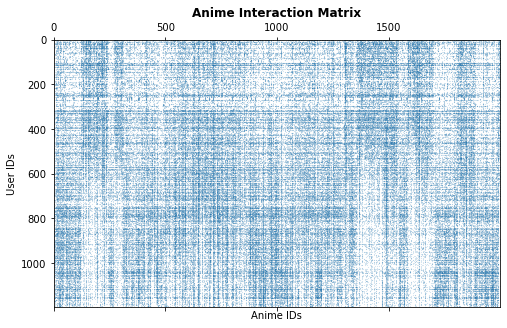

In [73]:
plt.figure(figsize = (8, 8))
plt.spy(adj.transpose(), markersize=0.05)
plt.xlabel('Anime IDs')
plt.ylabel('User IDs')
plt.title('Anime Interaction Matrix', fontweight = 'bold')
plt.savefig('interaction-matrix')
plt.show()

In [74]:
user_degrees = adj.sum(axis = 1)
print(user_degrees.shape)
item_degrees = adj.sum(axis = 0)
print(item_degrees.shape)

(2000,)
(1197,)


In [75]:
print('Max animes viewed by a user: ', user_degrees.max())
print('Min animes viewed by a user: ', user_degrees.min())
print('Avg animes viewed by a user: ', round(user_degrees.mean(), 1))

print('Most views for a anime: ', item_degrees.max())
print('Least views for a anime: ', item_degrees.min())
print('Avg views for a anime: ', round(item_degrees.mean(), 1))

Max animes viewed by a user:  593
Min animes viewed by a user:  30
Avg animes viewed by a user:  103.8
Most views for a anime:  1233
Least views for a anime:  50
Avg views for a anime:  173.5


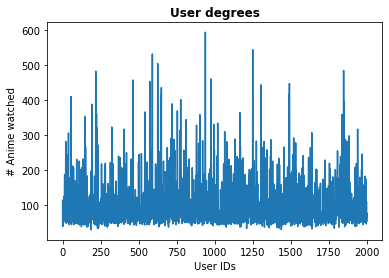

In [77]:
plt.plot(user_degrees)
plt.xlabel('User IDs')
plt.ylabel('# Anime watched')
plt.title('User degrees', fontweight = 'bold')
plt.savefig('user-degrees')
plt.show()

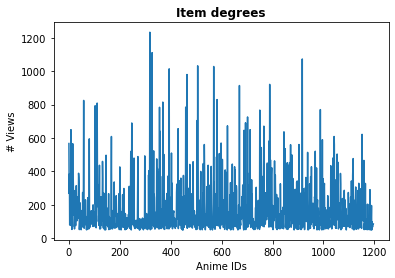

In [78]:
plt.plot(item_degrees)
plt.xlabel('Anime IDs')
plt.ylabel('# Views')
plt.title('Item degrees', fontweight = 'bold')
plt.savefig('item-degrees')
plt.show()

#### **Negative sampling**

In [79]:
density = n_samples / (n_users * n_items)
density

0.08674269005847954

In [80]:
data = pd.read_csv('anime_data_sampled.csv')
data

,user,item
0,0,80
1,0,103
2,0,167
3,0,197
4,0,200
...,...,...
207657,1999,811
207658,1999,821
207659,1999,827
207660,1999,831


In [81]:
pos_edges = dict()
neg_edges = dict()

for u in range(n_users):
    pos_edges[u] = set()
    neg_edges[u] = set()

# create sets of positive edges for each user
for _, row in data.iterrows():
    u = row.user
    i = row['item']
    pos_edges[u].add(i)

# create sets of negative edges for each user
for u in tqdm(range(n_users)):
    for i in range(n_items):
        if i not in pos_edges[u]:
            neg_edges[u].add(i)

100%|██████████| 2000/2000 [00:00<00:00, 3753.49it/s]


In [82]:
print(len(pos_edges[0]))
print(len(neg_edges[0]))
print(n_items)
# so far so good 

114
1083
1197


In [83]:
# sample negative edges for each user as neg_edges_sampled 
neg_edges_sampled = dict()
for u in tqdm(range(n_users)):
    # sample neg_edges for user u
    neg_edges_all = list(neg_edges[u])
    # sample same number of negative edges as positive edges for each user 
    # already checked that it is possible to do so 
    n_sampled_edges = len(pos_edges[u])
    neg_edges_sampled[u] = np.random.choice(neg_edges_all, size = n_sampled_edges, replace = False)
    neg_edges_sampled[u] = set(neg_edges_sampled[u])

100%|██████████| 2000/2000 [00:00<00:00, 8056.19it/s]


In [84]:
# merge pos_edges and neg_edges_sampled as train_edges, which is a dict()
train_edges = []
for u in tqdm(range(n_users)):
    for i in pos_edges[u]:
        train_edges.append((u, i, 1))
    for i in neg_edges_sampled[u]:
        train_edges.append((u, i, 0))
# shuffle train_edges to mix +ve and -ve edges
np.random.shuffle(train_edges)

100%|██████████| 2000/2000 [00:00<00:00, 18260.24it/s]


In [88]:
len(train_edges)
# twice the size of "data"

415324

In [89]:
# make train edges as 2d-array from list of tuples
train_edges_np = np.zeros(shape = (len(train_edges), 3), dtype = np.int32)
for i in range(len(train_edges)):
    user = train_edges[i][0]
    item = train_edges[i][1]
    rating = train_edges[i][2]
    train_edges_np[i] = np.array([user, item, rating])

# save the training edges
np.save('train_edges.npy', train_edges_np)

In [90]:
os.path.getsize('train_edges.npy') >> 20
# size of train_edges in MB

4